<a href="https://colab.research.google.com/github/glgunderson/INFOB2DA-PA4/blob/main/pa4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dashboard Visualizations and Coordinated View Systems**
## Practical Assignment 4 - INFOB2DA
*Tobias Buiten & Grace Gunderson*


In [ ]:
# Import Relevant Libraries for Level 2 Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
# Download Dataset from GitHub Release & Unzip Large Dataset
!curl -L -o DelayedFlights.zip "https://github.com/glgunderson/INFOB2DA-PA4/releases/download/PA4.DATA/DelayedFlights.zip"
!unzip -o DelayedFlights.zip -d data

import pandas as pd

# Load Dataset
df_raw = pd.read_csv('data/airlinedelaycauses_DelayedFlights.csv')

# Copy Dataset for Preprocessing
df = df_raw.copy()

# Preview Dataset
df_raw.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 62.0M  100 62.0M    0     0  47.7M      0  0:00:01  0:00:01 --:--:--  118M
Archive:  DelayedFlights.zip
  inflating: data/airlinedelaycauses_DelayedFlights.csv  


,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


## Dataset Overview

### DOT’S Air Travel Consumer Report:
The U.S. Department of Transportation’s (DOT) Bureau of Transportation Statistics (BTS) tracks the **on-time performance** of domestic flights operated by large air carriers.
- DOT provides **monthly summary information** on the number of on-time, delayed, cancelled and diverted flights.
- BTS collects details on the **causes of flight delays** and releases summary statistics and raw data.


## Summary Statistics

In [ ]:
# Understand the dataset
df_raw.info()
df_raw.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 30 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Year               int64  
 2   Month              int64  
 3   DayofMonth         int64  
 4   DayOfWeek          int64  
 5   DepTime            float64
 6   CRSDepTime         int64  
 7   ArrTime            float64
 8   CRSArrTime         int64  
 9   UniqueCarrier      object 
 10  FlightNum          int64  
 11  TailNum            object 
 12  ActualElapsedTime  float64
 13  CRSElapsedTime     float64
 14  AirTime            float64
 15  ArrDelay           float64
 16  DepDelay           float64
 17  Origin             object 
 18  Dest               object 
 19  Distance           int64  
 20  TaxiIn             float64
 21  TaxiOut            float64
 22  Cancelled          int64  
 23  CancellationCode   object 
 24  Diverted           int64  
 25  CarrierDelay      

(1936758, 30)

In [ ]:
# Basic Summary Statistics
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1936758.0,3.341651e+06,2.066065e+06,0.0,1517452.5,3242558.0,4972466.75,7009727.0
Year,1936758.0,2.008000e+03,0.000000e+00,2008.0,2008.0,2008.0,2008.00,2008.0
Month,1936758.0,6.111106e+00,3.482546e+00,1.0,3.0,6.0,9.00,12.0
DayofMonth,1936758.0,1.575347e+01,8.776272e+00,1.0,8.0,16.0,23.00,31.0
DayOfWeek,1936758.0,3.984827e+00,1.995966e+00,1.0,2.0,4.0,6.00,7.0
DepTime,1936758.0,1.518534e+03,4.504853e+02,1.0,1203.0,1545.0,1900.00,2400.0
CRSDepTime,1936758.0,1.467473e+03,4.247668e+02,0.0,1135.0,1510.0,1815.00,2359.0
ArrTime,1929648.0,1.610141e+03,5.481781e+02,1.0,1316.0,1715.0,2030.00,2400.0
CRSArrTime,1936758.0,1.634225e+03,4.646347e+02,0.0,1325.0,1705.0,2014.00,2400.0
FlightNum,1936758.0,2.184263e+03,1.944702e+03,1.0,610.0,1543.0,3422.00,9742.0


### Understanding the Dataset
The initial output upon loading the *full raw dataset* includes:
- **1,936,758 rows (flights) x 30 columns (features)**
- The columns consist of both numeric (`int64`, `float64`) and categorical (`object`) features, including:
  - 14 float variables (e.g., `DepTime`, `ArrTime`, `DepDelay`, `ArrDelay`)
  - 11 integer variables (e.g., `Year`, `Month`, `DayofWeek`, `FlightNum`)
  - 5 object variables (e.g., `UniqueCarrier`, `Origin`, `Dest`)  

According to PA4, the dataset *should* include:
- Flight delay metrics for **1,247,486** different flights.
- **30 different features**, both numerical and categorical.

### Understanding the Record Discrepancy
The difference between the ~1.94 million and ~1.25 million flight records is explained by *dataset scope*.
- The full raw dataset (**1,936,758 rows**) includes **all scheduled flights** in 2008 - whether they were on time, delayed, cancelled, or diverted.
- Only a subset of the flight records (**1,247,488 rows**) contain complete **delay-related data** (`CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`).
  - These represent flights that actually experienced a *delay event*, which is the primary focus of this data analysis.

As a result, all preprocessing and subsequent visualizations are performed on this ~1.25M delayed-flight subset to ensure meaningful data analysis.

## Preprocessing

In [ ]:
# PREPROCESSING

# Drop redundant/irrelevant columns
df = df.drop(columns=['Unnamed: 0', 'Year'])

# Remove cancelled or diverted flights
df = df[(df['Cancelled'] == 0) & (df['Diverted'] == 0)]

# Identify records with complete delay-cause data
delayed = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
df = df.dropna(subset=delayed)

# Drop rows missing essential delay information
df = df.dropna(subset=['ArrDelay'])

# Fill missing delay-cause values (NaN) with 0
df[delayed] = df[delayed].fillna(0)

# Clip negative delay values (representing early arrivals) to 0
df['ArrDelay'] = df['ArrDelay'].clip(lower=0)

# Derive new time-based features for later visualization
df['DepHour'] = (df['DepTime'] // 100).astype(int)
df['ArrHour'] = (df['ArrTime'] // 100).astype(int)

# Reset DataFrame index to ensure clean row alignment
df = df.reset_index(drop=True)

# Verify structure after preprocessing
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247488 entries, 0 to 1247487
Data columns (total 30 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Month              1247488 non-null  int64  
 1   DayofMonth         1247488 non-null  int64  
 2   DayOfWeek          1247488 non-null  int64  
 3   DepTime            1247488 non-null  float64
 4   CRSDepTime         1247488 non-null  int64  
 5   ArrTime            1247488 non-null  float64
 6   CRSArrTime         1247488 non-null  int64  
 7   UniqueCarrier      1247488 non-null  object 
 8   FlightNum          1247488 non-null  int64  
 9   TailNum            1247486 non-null  object 
 10  ActualElapsedTime  1247488 non-null  float64
 11  CRSElapsedTime     1247488 non-null  float64
 12  AirTime            1247488 non-null  float64
 13  ArrDelay           1247488 non-null  float64
 14  DepDelay           1247488 non-null  float64
 15  Origin             1247488 non-n

(1247488, 30)

### Data Preprocessing
## 🧹 Data Preprocessing

*Before visualizing flight delay trends, the dataset required preprocessing to ensure data analysis focuses only on valid, delayed flight records.*

### 1. Removed redundant and irrelevant columns
- The first column, **Unnamed: 0**, is an index column automatically generated during export and does not represent a meaningful feature.
- Dropped `Year` since all records were from 2008 (constant value), offering no variance for analysis.

### 2. Excluded cancelled or diverted flights
- Removed flights where `Cancelled = 1` or `Diverted = 1`.  
- These records do not have valid arrival/departure data, which is essential for delay analysis.

### 3. Retained only records with complete delay-cause data
- Filtered to include only rows where all five delay cause fields were present:  
  `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`.  
- This isolates the ~1.25 million delayed-flight subset that contains full delay-cause information — the focus of this data analysis.

### 4. Dropped missing arrival delay values
- `ArrDelay` had 1,928,371 non-null records out of 1,936,758.  
- Rows missing `ArrDelay` were removed to ensure valid arrival delay metrics for analysis.  
- `DepDelay` was already complete, so no removal was necessary.

### 5. Filled missing delay-cause values with zero
- Any remaining `NaN` values in delay-cause columns were replaced with `0`
- NaN indicated *no delay* from that cause (e.g., `WeatherDelay`).

### 6. Clipped negative arrival delay values
- Negative values in `ArrDelay` represent early arrivals (e.g., `-109` = 109 minutes early).  
- To focus purely on delays, these were clipped to `0`, indicating no delay.  
- `DepDelay` contained no negative values, so no adjustment was required.

### 7. Derived new time-based features
- Created `DepHour` and `ArrHour` by converting scheduled departure/arrival times (e.g., `1530`) to hour bins (e.g., `15`).  
- This facilitates later visualization of delay patterns by time of day.

### 8. Reset DataFrame index
- Reset the index after all filtering steps to maintain continuous row alignment.

### Summary
After preprocessing:
- Rows reduced from **1,936,758** to **1,247,488**.
- Columns remained **30**, with two new derived features (`DepHour`, `ArrHour`).  
- Resulting dataset represents all recorded data for **delayed flights in 2008** that experienced measurable delay causes.


In [ ]:
# Basic summary statistics after preprocessing
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Month,1247488.0,6.065395,3.508936,1.0,3.0,6.0,9.0,12.0
DayofMonth,1247488.0,15.725431,8.793011,1.0,8.0,16.0,23.0,31.0
DayOfWeek,1247488.0,3.980082,1.993270,1.0,2.0,4.0,6.0,7.0
DepTime,1247488.0,1558.832181,454.329706,1.0,1232.0,1618.0,1924.0,2400.0
CRSDepTime,1247488.0,1487.949046,421.177919,0.0,1150.0,1529.0,1830.0,2359.0
ArrTime,1247488.0,1616.749476,583.941345,1.0,1326.0,1737.0,2048.0,2400.0
CRSArrTime,1247488.0,1652.457729,461.736974,0.0,1340.0,1722.0,2022.0,2359.0
FlightNum,1247488.0,2276.529725,1997.548096,1.0,637.0,1589.0,3676.0,9741.0
ActualElapsedTime,1247488.0,135.377881,72.296306,14.0,83.0,118.0,167.0,1114.0
CRSElapsedTime,1247488.0,131.764029,69.531965,-21.0,80.0,115.0,161.0,660.0


In [ ]:
print(f"Raw dataset shape: {df_raw.shape}")
print(f"Cleaned dataset shape: {df.shape}")
print(f"Rows removed during preprocessing: {df_raw.shape[0] - df.shape[0]:,}")

Raw dataset shape: (1936758, 30)
Cleaned dataset shape: (1247488, 30)
Rows removed during preprocessing: 689,270


In [ ]:
# Delays greater than 24 hours
(df['ArrDelay'] > 1440).sum(), (df['DepDelay'] > 1440).sum(), (df['CarrierDelay'] > 1440).sum()

(np.int64(10), np.int64(10), np.int64(8))

## Analyze Dataset

In [ ]:
# Experiment with basic charts/visualizations

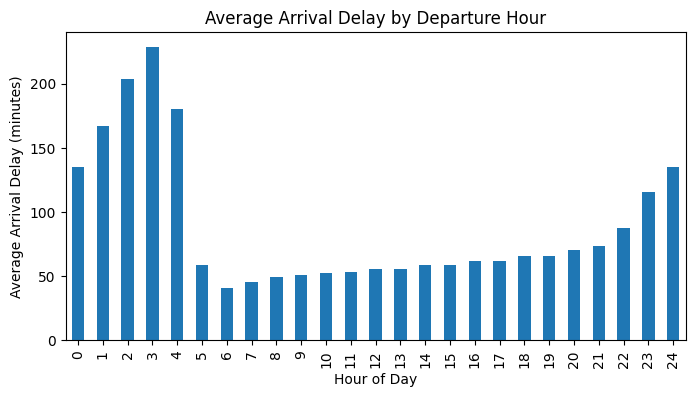

In [ ]:
df.groupby('DepHour')['ArrDelay'].mean().plot(kind='bar', figsize=(8,4))
plt.title("Average Arrival Delay by Departure Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Arrival Delay (minutes)")
plt.show()

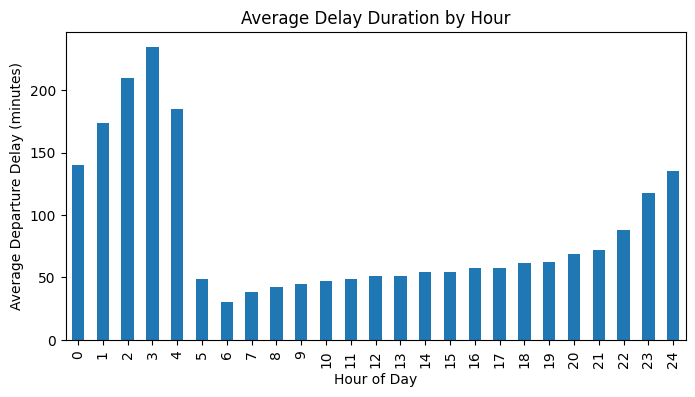

In [ ]:
df.groupby('DepHour')['DepDelay'].mean().plot(kind='bar', figsize=(8,4))
plt.title("Average Delay Duration by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Departure Delay (minutes)")
plt.show()

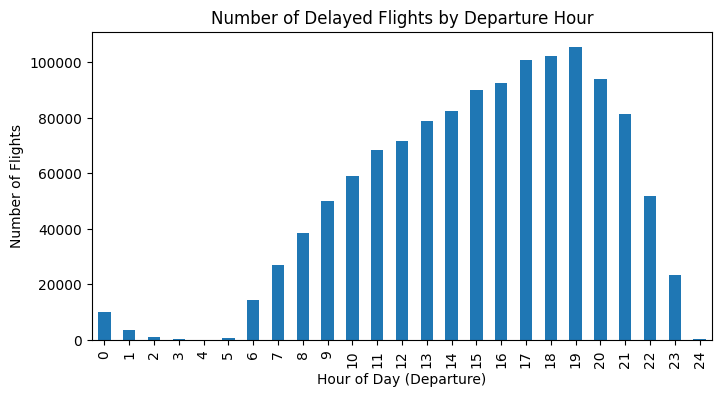

In [ ]:
df['DepHour'].value_counts().sort_index().plot(kind='bar', figsize=(8,4))
plt.title("Number of Delayed Flights by Departure Hour")
plt.xlabel("Hour of Day (Departure)")
plt.ylabel("Number of Flights")
plt.show()

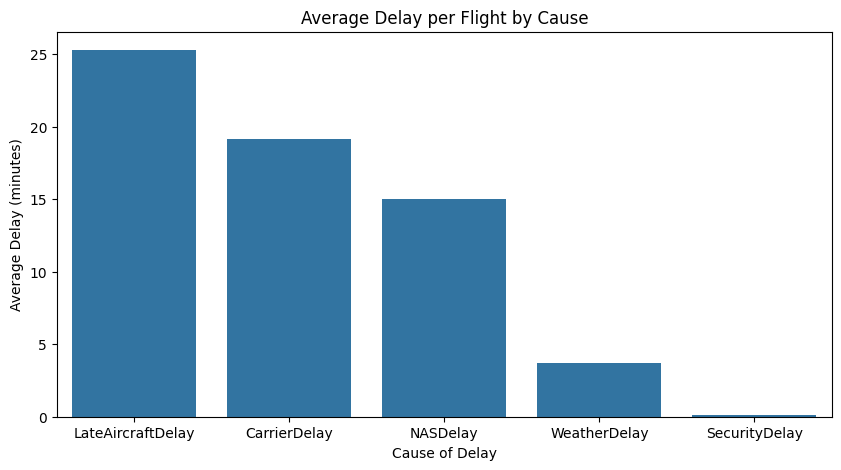

In [ ]:
avg_delays = df[delayed].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=avg_delays.index, y=avg_delays.values)
plt.title("Average Delay per Flight by Cause")
plt.xlabel("Cause of Delay")
plt.ylabel("Average Delay (minutes)")
plt.show()

In [ ]:
# Count of delayed flights per month
monthly_counts = df['Month'].value_counts().sort_index()

# Convert to percentage of total delayed flights
monthly_percent = (monthly_counts / monthly_counts.sum()) * 100

# Create a DataFrame for Plotly
monthly_data = monthly_percent.reset_index()
monthly_data.columns = ['Month', 'PercentDelayed']

# Replace month numbers with names
monthly_data['Month'] = monthly_data['Month'].replace({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
    7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
})


fig = px.area(
    monthly_data,
    x='Month',
    y='PercentDelayed',
    title='Flight Delays by Month',
    labels={'PercentDelayed':'% of Delayed Flights'},
)
fig.show()

In [ ]:
# Sum delay causes by month (for all flights)
monthly_cause = df_raw.groupby('Month')[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].sum()

# Calculate percentage of total delay minutes
monthly_percent = monthly_cause.div(monthly_cause.sum().sum(), axis=0) * 100

# Convert month numbers to names
monthly_percent = monthly_percent.reset_index()
monthly_percent['Month'] = monthly_percent['Month'].replace({
    1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
    7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
})

# Plot
fig = px.area(
    monthly_percent,
    x='Month',
    y=['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
    title='Delay Causes by Month',
    labels={'value':'% of Total Delay Minutes', 'variable':'Delay Cause'}
)

fig.show()

In [ ]:
(df[['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']] > 0).sum()

,0
CarrierDelay,656439
WeatherDelay,98918
NASDelay,658493
SecurityDelay,6005
LateAircraftDelay,691582


In [ ]:
# Calculate average delay minutes per cause for each month
monthly_avg = (
    df.groupby('Month')[['CarrierDelay','WeatherDelay','NASDelay','LateAircraftDelay']]
    .mean()
    .reset_index()
)

# Replace month numbers with names for readability
monthly_avg['Month'] = monthly_avg['Month'].replace({
    1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
    7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
})

# Plot all 5 causes in one interactive line chart
fig = px.line(
    monthly_avg,
    x='Month',
    y=['CarrierDelay','WeatherDelay','NASDelay','LateAircraftDelay'],
    markers=True,
    title='Average Delay per Flight by Month and Cause',
    labels={'value':'Average Delay (minutes)', 'variable':'Delay Cause'},
)

fig.show()

# **INTERACTIVE VISUALIZATION DASHBOARD**

## **Visualization 1**

In [ ]:
# 1

### Conclusion

## **Visualization 2**

In [ ]:
# 2

### Conclusion

## **Visualization 3**

In [ ]:
# 3

### Conclusion

## **Visualization 4**

In [ ]:
# 4

### Conclusion



## **Visualization 5**

In [ ]:
# 5

### Conclusion